In [1]:
import logging
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
logging.basicConfig(level=logging.INFO, force=True)
import os
csv_file_path = "/data/air/pc/Mobile-Search-Engine/datasets/clotho/clotho_captions_evaluation.csv"
data_dir="/data/air/pc/Mobile-Search-Engine/datasets/clotho/evaluation"
# f_s=os.listdir(data_dir)
# print(len(f_s))
pf=pd.read_csv(csv_file_path,sep=',') # 假设数据集以CSV文件形式提供
text_list = pf[['caption_1', 'caption_2', 'caption_3', 'caption_4', 'caption_5']].values.flatten().tolist()
audio_list=pf[['file_name']].values.flatten().tolist()
audio_path=["/data/air/pc/Mobile-Search-Engine/datasets/clotho/evaluation/"+file for file in audio_list]
import random
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



/home/cdq/.conda/envs/search/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def find_first_nonzero_row(array, column_index):
    for i, row in enumerate(array):
        if row[column_index] != 0:
            return i
    return 12

# Define a function to calculate the sum of an array
def array_sum(arr):
    return sum(arr)

filenames = ['t24_a{0}.txt'.format(i) for i in range(1,13)]
files = [os.path.join('/data/air/pc/Mobile-Search-Engine/results/clotho/R10',file) for file in filenames]
counts = np.array([])
counts = [np.loadtxt(file) for file in files]
audio_layers={}
for i in range(len(audio_list)):
    audio_layers[i]=[]
for i in range(len(audio_list)):
    audio_id=i
    for j in range(5*audio_id,5*audio_id+5):        
        audio_layers[i].append(find_first_nonzero_row(np.array(counts),j))


sums_and_indices = [(sum(audio_layers[i]), i) for i in range(len(audio_layers))]

# Sort the sums and indices based on the sums
sorted_sums_and_indices = sorted(sums_and_indices, key=lambda x: x[0])

# Extract sorted sums and corresponding indices
sorted_sums = [item[0] for item in sorted_sums_and_indices]
sorted_indices = [item[1] for item in sorted_sums_and_indices]

audio_result=sorted_indices[0:10]+sorted_indices[500:510]+sorted_indices[1000:1010]
embeddings={}
embeddings_average={}
with torch.no_grad():
    for i in range(1,13):
        embeddings[f'layer_{i}']=[]
        embeddings_average[f'layer_{i}']=[]
    for a_block in range(1,13):
        checkpoint = torch.load(f'/data/air/pc/Mobile-Search-Engine/embeddings_{a_block}.pth')
        # 获取模型参数和张量
        emb= checkpoint['audio_embeddings']
        for k in audio_result:
            embeddings[f'layer_{a_block}'].append(emb[int(k)])
        for i in range(3):
                sum_vector = torch.stack(embeddings[f'layer_{a_block}'][i:i+10]).sum(dim=0)

                # 计算平均向量
                mean_vector = sum_vector / 10

                embeddings_average[f'layer_{a_block}'].append(mean_vector)
                # averages = [torch.mean(tensor).view(1) for tensor in embeddings[f'layer_{a_block}'][i:i+10]]
                # # Concatenate the average vectors into a single vector
                # embeddings_average[f'layer_{a_block}']= torch.cat(averages)
                # # mean=[torch.mean(tensor) for tensor in embeddings[f'layer_{a_block}'][i:i+10]]  
                # # embeddings_average[f'layer_{a_block}']=torch.cat(mean)





/tmp/ipykernel_26181/514381907.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


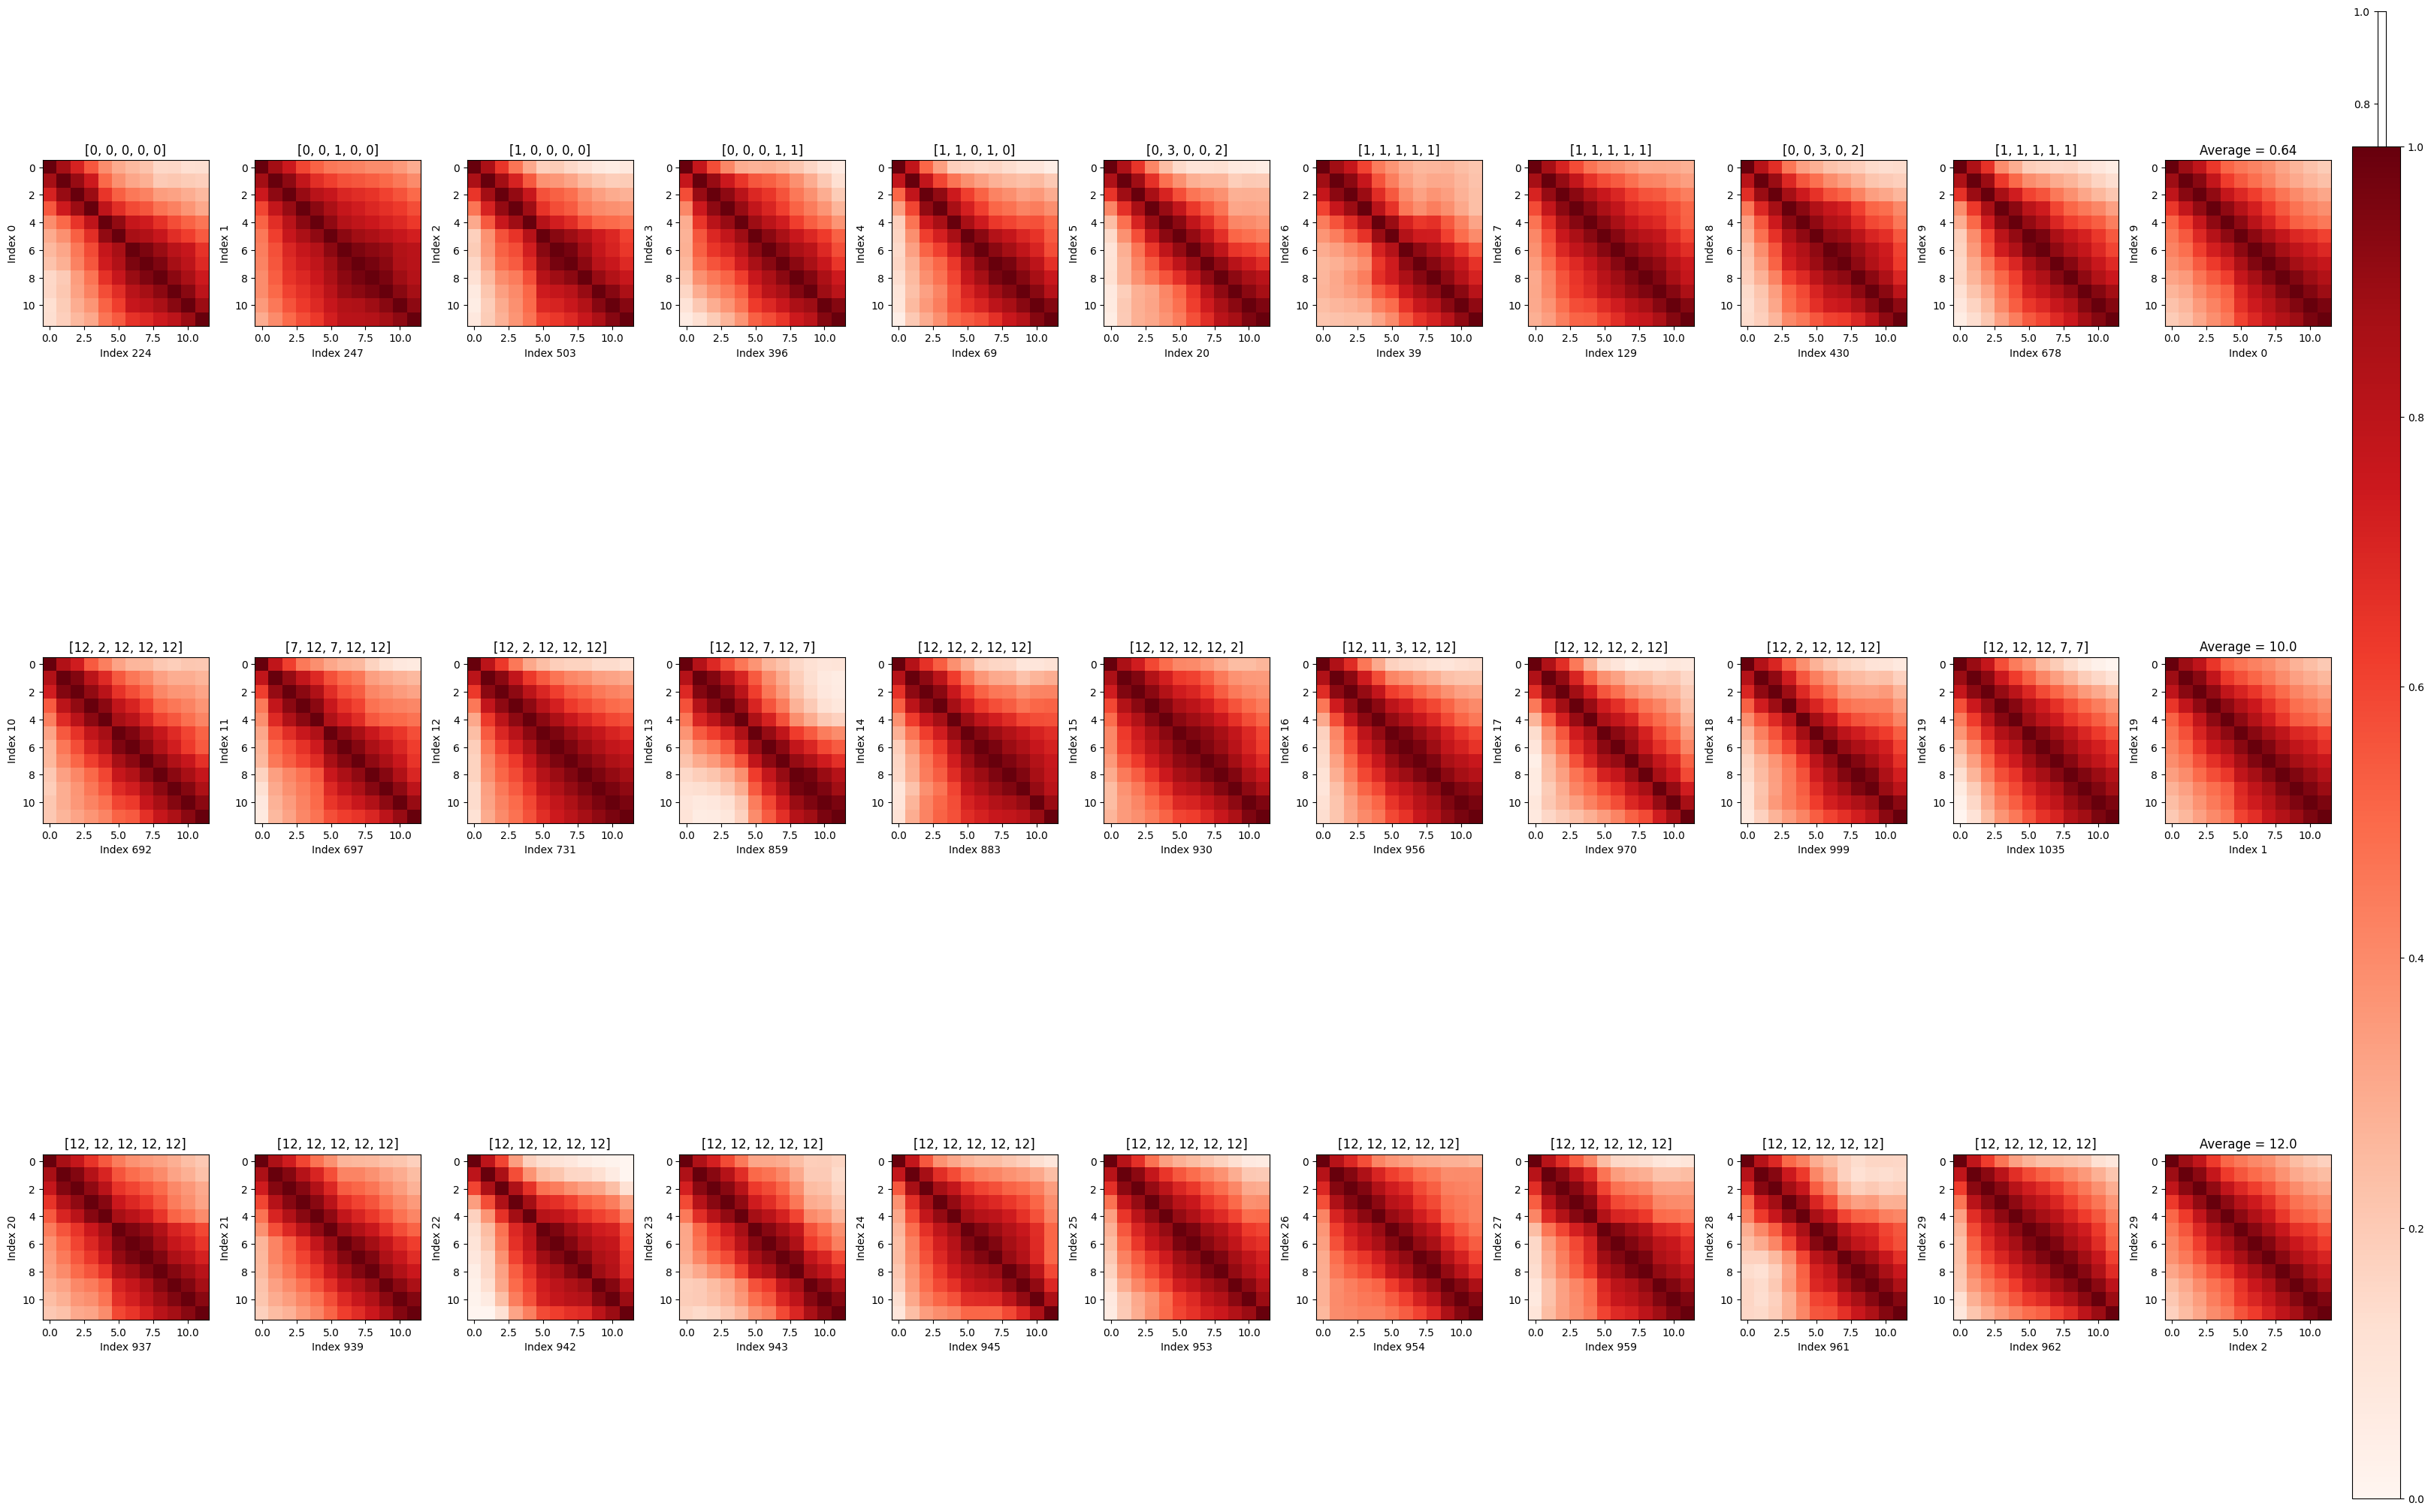

In [3]:
fig, axes = plt.subplots(3, 12, figsize=(32, 20), gridspec_kw={'width_ratios': [1]*11 + [0.05]})
cmap_color = 'Reds'
# 对每组子图进行处理
for n in range(3):
    for m in range(11):
        k = n * 10 + m
        ax = axes[n, m]  # 使用正确的索引
        
        
        if m!=10:
            ax.set_title(f'{audio_layers[audio_result[k]]}')
            

            similarity_matrix = np.zeros((12, 12))

            # 计算相似度矩阵的值
            for i in range(12):
                for j in range(i, 12):  # 避免重复计算，只计算上三角部分
                    embeddings[f'layer_{i+1}'][k] = embeddings[f'layer_{i+1}'][k].to(device)
                    embeddings[f'layer_{j+1}'][k] = embeddings[f'layer_{j+1}'][k].to(device)
                    similarity = F.cosine_similarity(embeddings[f'layer_{i+1}'][k], embeddings[f'layer_{j+1}'][k], dim=0)
                    similarity_matrix[i, j] = similarity
                    similarity_matrix[j, i] = similarity  # 对称矩阵，填充对角线上的值

            # 绘制相似度矩阵
            im = ax.imshow(similarity_matrix, cmap=cmap_color, vmin=0, vmax=1)

            # 设置坐标轴标签
            ax.set_xlabel(f'Index {audio_result[k]}')
            ax.set_ylabel(f'Index {k}')
        elif m==10:
            average=0
            for k in range(n*10,n*10+10):
                average+=sum(audio_layers[audio_result[k]])
            ax.set_title(f'Average = {average/50 }')
            

            similarity_matrix = np.zeros((12, 12))
            
            # 计算相似度矩阵的值
            for i in range(12):
                for j in range(i, 12):  # 避免重复计算，只计算上三角部分
                    embeddings_average[f'layer_{i+1}'][n] = embeddings_average[f'layer_{i+1}'][n].to(device)
                    embeddings_average[f'layer_{j+1}'][n] = embeddings_average[f'layer_{j+1}'][n].to(device)
                    similarity = F.cosine_similarity(embeddings_average[f'layer_{i+1}'][n], embeddings_average[f'layer_{j+1}'][n], dim=0)
                    similarity_matrix[i, j] = similarity
                    similarity_matrix[j, i] = similarity  # 对称矩阵，填充对角线上的值

            # 绘制相似度矩阵
            im = ax.imshow(similarity_matrix, cmap=cmap_color, vmin=0, vmax=1)

            # 设置坐标轴标签
            ax.set_xlabel(f'Index {n}')
            ax.set_ylabel(f'Index {k}')
# 在大图的最右边显示颜色条
cbar_ax = fig.add_axes([0.98, 0, 0.02, 0.9])  # 调整颜色条位置和大小
plt.colorbar(im, cax=cbar_ax)

plt.tight_layout()

# 保存图像
plt.savefig('../figs/audio_similarity_matrices_heatmap.png')

/tmp/ipykernel_2375/3743223905.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


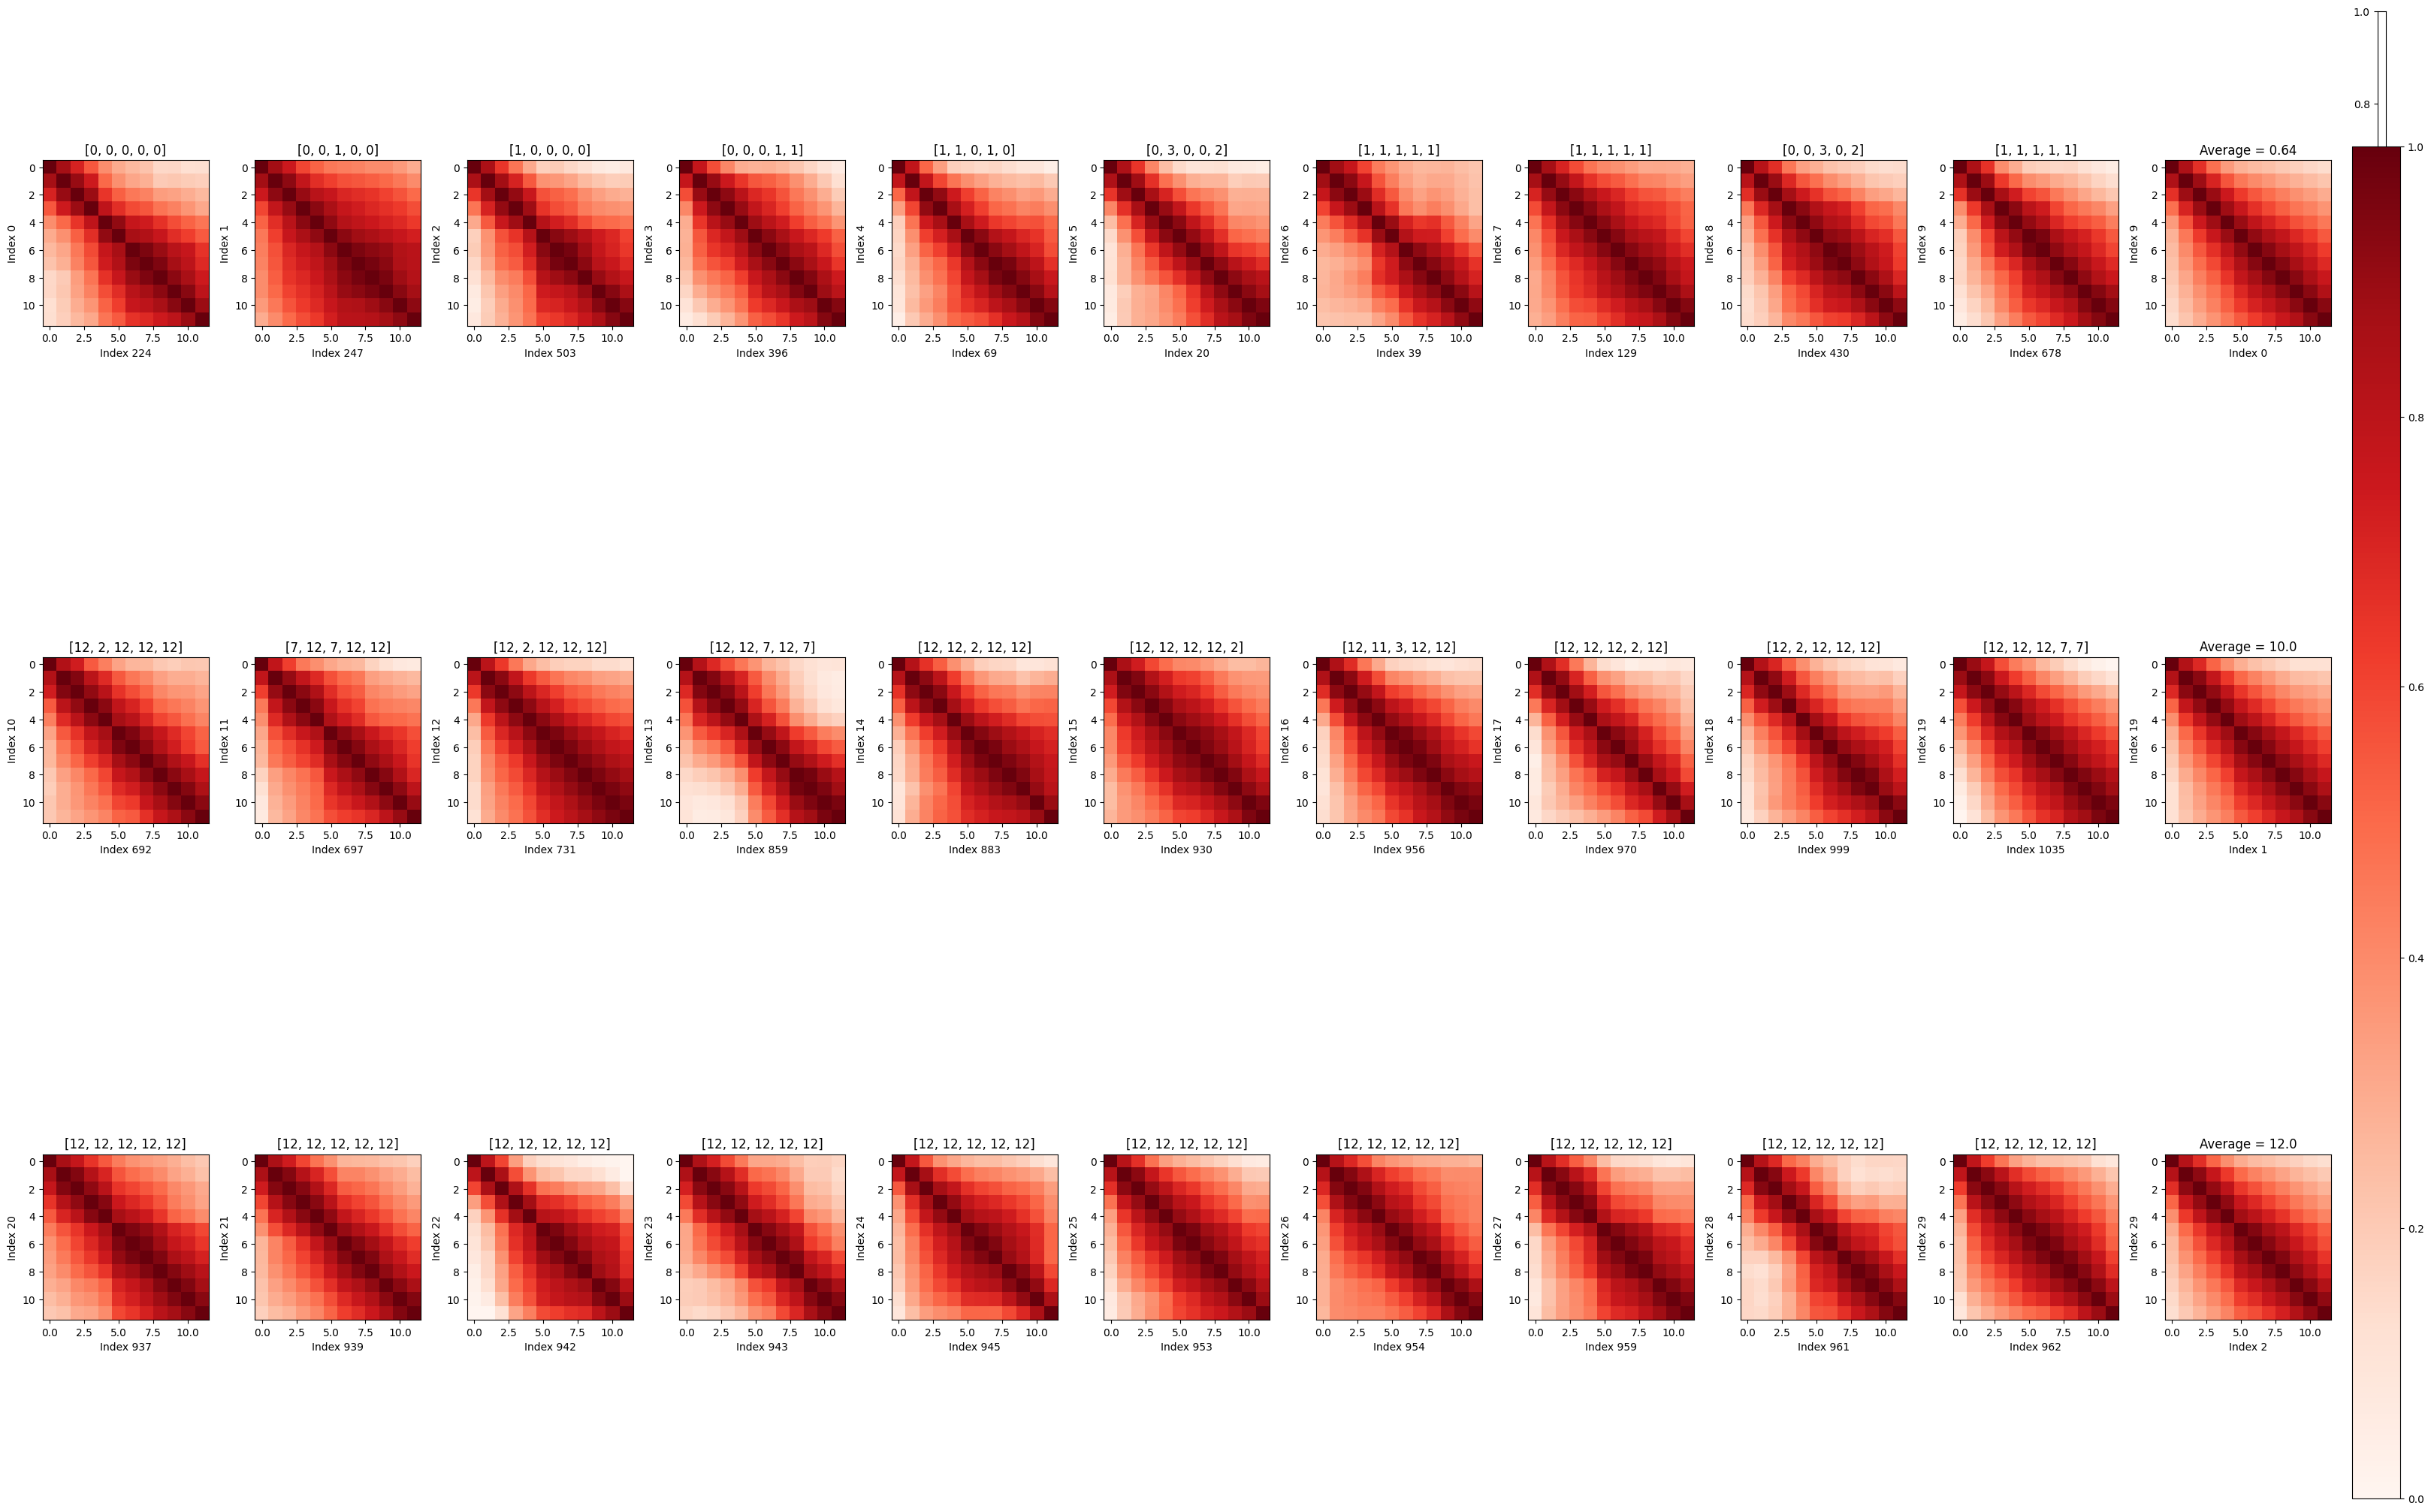

In [8]:
# similarity adding instead of raw audio adding

fig, axes = plt.subplots(3, 12, figsize=(32, 20), gridspec_kw={'width_ratios': [1]*11 + [0.05]})
cmap_color = 'Reds'
# 对每组子图进行处理
for n in range(3):
    similarity_matrix_list = []
    for m in range(10):
        k = n * 10 + m
        ax = axes[n, m]  # 使用正确的索引
        
        
        if m!=10:
            ax.set_title(f'{audio_layers[audio_result[k]]}')
            

            similarity_matrix = np.zeros((12, 12))

            # 计算相似度矩阵的值
            for i in range(12):
                for j in range(i, 12):  # 避免重复计算，只计算上三角部分
                    embeddings[f'layer_{i+1}'][k] = embeddings[f'layer_{i+1}'][k].to(device)
                    embeddings[f'layer_{j+1}'][k] = embeddings[f'layer_{j+1}'][k].to(device)
                    similarity = F.cosine_similarity(embeddings[f'layer_{i+1}'][k], embeddings[f'layer_{j+1}'][k], dim=0)
                    similarity_matrix[i, j] = similarity
                    similarity_matrix[j, i] = similarity  # 对称矩阵，填充对角线上的值
            similarity_matrix_list.append(similarity_matrix)
            # 绘制相似度矩阵
            im = ax.imshow(similarity_matrix, cmap=cmap_color, vmin=0, vmax=1)

            # 设置坐标轴标签
            ax.set_xlabel(f'Index {audio_result[k]}')
            ax.set_ylabel(f'Index {k}')
    ax = axes[n, 10]  # 使用正确的索引
    average=0
    for k in range(n*10,n*10+10):
        average+=sum(audio_layers[audio_result[k]])
    ax.set_title(f'Average = {average/50 }')
    similarity_matrix_average = np.mean(similarity_matrix_list, axis=0)
    # 绘制相似度矩阵
    im = ax.imshow(similarity_matrix_average, cmap=cmap_color, vmin=0, vmax=1)

    # 设置坐标轴标签
    ax.set_xlabel(f'Index {n}')
    ax.set_ylabel(f'Index {k}')
# 在大图的最右边显示颜色条
cbar_ax = fig.add_axes([0.98, 0, 0.02, 0.9])  # 调整颜色条位置和大小
plt.colorbar(im, cax=cbar_ax)

plt.tight_layout()

# 保存图像
plt.savefig('../figs/audio_similarity_matrices_heatmap_new.png')



